In [1]:
import MGTomo.model as mgmodel
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch

from MGTomo.gridop import P,R

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 1
maxIter = [5,5]

In [3]:
N = 1023
# load image
x_orig = shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
c0 = 56.0952

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [7]:
tau0 = 0.5 * 1/c0

In [9]:
z0 = torch.rand(1023, 1023, requires_grad = True)
for i in range(100):
    val = fcts.SMART(fh, z0, tau0)
    z0 = val.clone().detach().requires_grad_(True)
    
    assert z0.grad is None
    print(i, ': ', fh(z0))

0 :  tensor(477739.9179, dtype=torch.float64, grad_fn=<AddBackward0>)
1 :  tensor(286902.0994, dtype=torch.float64, grad_fn=<AddBackward0>)
2 :  tensor(207596.4382, dtype=torch.float64, grad_fn=<AddBackward0>)
3 :  tensor(164382.5297, dtype=torch.float64, grad_fn=<AddBackward0>)
4 :  tensor(135820.4624, dtype=torch.float64, grad_fn=<AddBackward0>)
5 :  tensor(114842.8866, dtype=torch.float64, grad_fn=<AddBackward0>)
6 :  tensor(98604.3050, dtype=torch.float64, grad_fn=<AddBackward0>)
7 :  tensor(85669.1682, dtype=torch.float64, grad_fn=<AddBackward0>)
8 :  tensor(75169.7860, dtype=torch.float64, grad_fn=<AddBackward0>)
9 :  tensor(66522.3941, dtype=torch.float64, grad_fn=<AddBackward0>)
10 :  tensor(59312.0145, dtype=torch.float64, grad_fn=<AddBackward0>)
11 :  tensor(53234.7737, dtype=torch.float64, grad_fn=<AddBackward0>)
12 :  tensor(48063.7000, dtype=torch.float64, grad_fn=<AddBackward0>)
13 :  tensor(43626.5205, dtype=torch.float64, grad_fn=<AddBackward0>)
14 :  tensor(39790.5196,

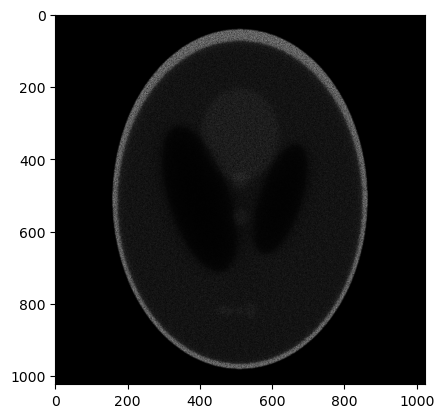

In [10]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')